In [61]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator

from qiskit.compiler import transpile
from qiskit.circuit import Parameter

from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt


In [62]:
qc = QuantumCircuit(2)
gamma = 0.3
qc.rzz(.3, 0, 1)
print(qc)

               
q_0: ─■────────
      │ZZ(0.3) 
q_1: ─■────────
               


In [63]:
# define problem
n_rows = 3
n_cols = 3

# Set external magnetic field at each site
h = 0.5
field = h * np.ones((n_rows, n_cols))


# Create a quantum register with enough qubits for the grid

qr = QuantumRegister(n_rows * n_cols)
cr = ClassicalRegister(n_rows * n_cols)
qc = QuantumCircuit(qr)

# Map the qubits into a 2D grid to represent Ising model
qubits = [[qr[i * n_cols + j] for j in range(n_cols)] for i in range(n_rows)]
print(qubits)
qubits = np.array(qubits)


[[Qubit(QuantumRegister(9, 'q16'), 0), Qubit(QuantumRegister(9, 'q16'), 1), Qubit(QuantumRegister(9, 'q16'), 2)], [Qubit(QuantumRegister(9, 'q16'), 3), Qubit(QuantumRegister(9, 'q16'), 4), Qubit(QuantumRegister(9, 'q16'), 5)], [Qubit(QuantumRegister(9, 'q16'), 6), Qubit(QuantumRegister(9, 'q16'), 7), Qubit(QuantumRegister(9, 'q16'), 8)]]


In [64]:
def prepare_circuit(qc, qubits):
    n_rows, n_cols = qubits.shape
    for row in range(n_rows):
        for col in range(n_cols):
            qc.h(qubits[row, col])

In [65]:
def apply_gamma_unitary(qc, qubits, mag_field, gamma):
    n_rows, n_cols = mag_field.shape
    for row in range(n_rows):
        for col in range(n_cols):
            if row < n_rows - 1:
                qc.rzz(gamma, qubits[row, col], qubits[row + 1, col])
            if col < n_cols - 1:
                qc.rzz(gamma, qubits[row, col], qubits[row, col + 1])
            qc.rz(gamma * mag_field[row, col], qubits[row, col])

In [66]:
def apply_beta_unitary(qc, qubits, beta):
    n_rows, n_cols = qubits.shape
    for row in range(n_rows):
        for col in range(n_cols):
            qc.rx(beta, qubits[row, col])

In [67]:
def apply_measurements(qc, qubits):
    n_rows, n_cols = qubits.shape
    for row in range(n_rows):
        for col in range(n_cols):
            qc.measure(qubits[row, col])

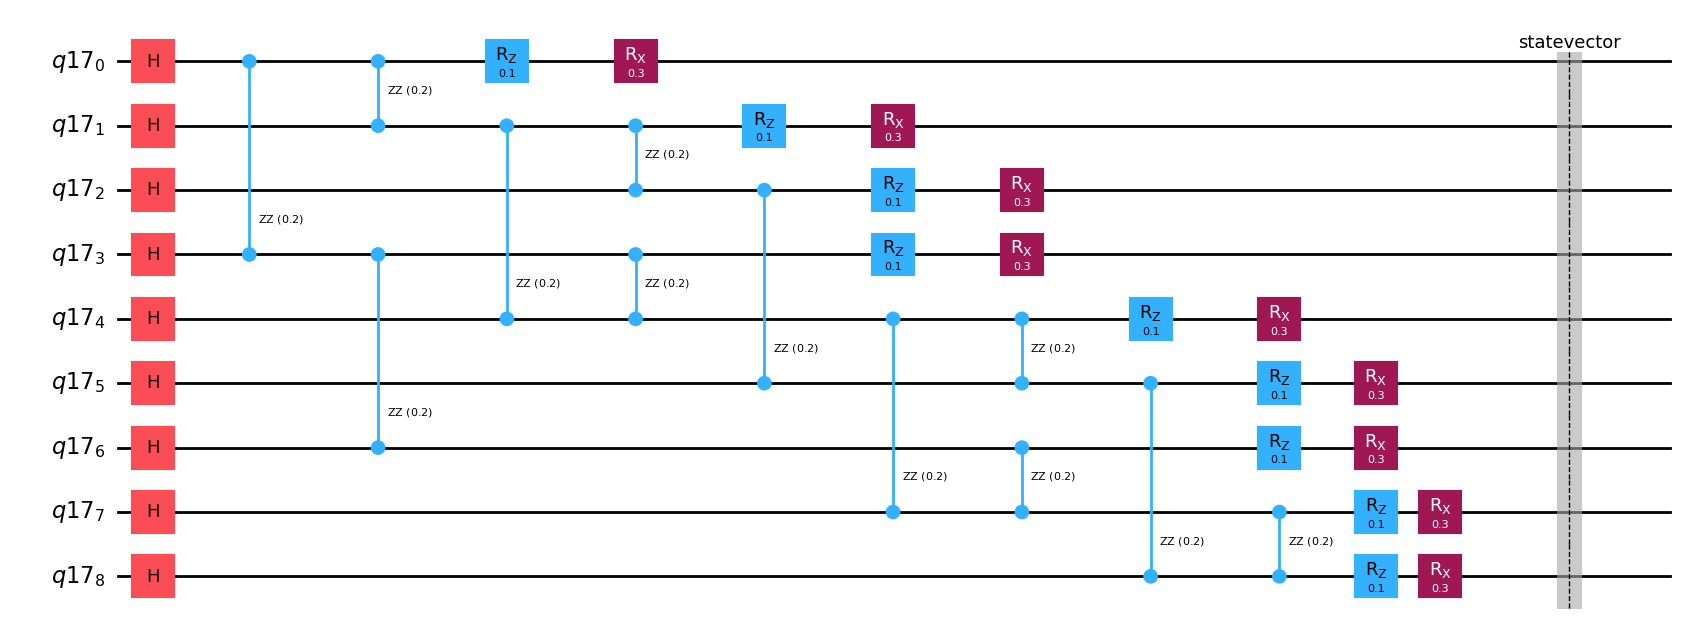

In [68]:

# define problem
n_rows = 3
n_cols = 3
gamma = 0.3
beta = 0.7

gamma_param = Parameter("gamma")
beta_param = Parameter("beta")

# Set external magnetic field at each site
h = 0.5
h_field = h * np.ones((n_rows, n_cols))


# Create a quantum register with enough qubits for the grid

qr = QuantumRegister(n_rows * n_cols)

qc = QuantumCircuit(qr)
# Map the qubits into a 2D grid to represent Ising model
qubits = [[qr[i * n_cols + j] for j in range(n_cols)] for i in range(n_rows)]
qubits = np.array(qubits)

prepare_circuit(qc, qubits)
apply_gamma_unitary(qc, qubits, h_field, gamma_param)  # Use gamma_param
apply_beta_unitary(qc, qubits, beta_param)          # Use beta_param

#measurement_qc = qc.copy()
#apply_measurements(measurement_qc, qubits)


qc.save_statevector()
#measurement_qc.save_statevector()

simulator = AerSimulator(method='statevector')


gamma_value = .2
beta_value = .3
bound_circuit = qc.assign_parameters({"gamma": gamma_value, "beta": beta_value})
transpiled_circuit = transpile(bound_circuit, simulator)

bound_circuit.draw('mpl')


In [69]:
## Now we must find optimal values of params 
def energy_from_wavefunction(wf, h):
    """Computes the energy-per-site of the Ising model directly from the
    a given wavefunction.

    Args:
        wf: Array of size 2**(n_rows * n_cols) specifying the wavefunction.
        h: Array of shape (n_rows, n_cols) giving the magnetic field values.

    Returns:
        energy: Float equal to the expectation value of the energy per site
    """
    n_sites = n_rows * n_cols

    # Z is an array of shape (n_sites, 2**n_sites). Each row consists of the
    # 2**n_sites non-zero entries in the operator that is the Pauli-Z matrix on
    # one of the qubits times the identities on the other qubits. The
    # (i*n_cols + j)th row corresponds to qubit (i,j).
    Z = np.array(
        [(-1) ** (np.arange(2**n_sites) >> i) for i in range(n_sites - 1, -1, -1)]
    )

    # Create the operator corresponding to the interaction energy summed over all
    # nearest-neighbor pairs of qubits
    ZZ_filter = np.zeros_like(wf, dtype=float)
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[(i + 1) * n_cols + j]
            if j < n_cols - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[i * n_cols + (j + 1)]

    energy_operator = -ZZ_filter - h.reshape(n_sites).dot(Z)

    # Expectation value of the energy divided by the number of sites
    return np.sum(np.abs(wf) ** 2 * energy_operator) / n_sites

In [70]:
def energy_from_params(
    gamma_value, beta_value: float, qaoa: QuantumCircuit, h: np.ndarray, display
) -> float:
    """Returns the energy given values of the parameters."""
    bound_circuit = qaoa.assign_parameters({"gamma": gamma_value, "beta": beta_value})
    if (display):
        print(bound_circuit)
    # Simulate the circuit to get the final wavefunction
    simulator = AerSimulator(method="statevector")
    transpiled_circuit = transpile(bound_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    final_state = result.get_statevector()
    if (display):
        print(final_state)
    
    # Compute energy using the energy_from_wavefunction function
    return energy_from_wavefunction(final_state, h)

In [71]:
"""Do a grid search over values of 𝛄 and β."""
# Set the grid size and range of parameters.
grid_size = 50
gamma_max = 2
beta_max = 2

# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        if (i == 1 and j == 1):
            display = True
        else:
            display = False
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, qc, h_field, display
        )

       ┌───┐                      ┌──────────┐┌──────────┐            »
q17_0: ┤ H ├─■──────────■─────────┤ Rz(0.02) ├┤ Rx(0.04) ├────────────»
       ├───┤ │          │ZZ(0.04) └──────────┘└──────────┘┌──────────┐»
q17_1: ┤ H ├─┼──────────■──────────■───────────■──────────┤ Rz(0.02) ├»
       ├───┤ │                     │           │ZZ(0.04)  └──────────┘»
q17_2: ┤ H ├─┼─────────────────────┼───────────■───────────■──────────»
       ├───┤ │ZZ(0.04)             │                       │          »
q17_3: ┤ H ├─■──────────■──────────┼───────────■───────────┼──────────»
       ├───┤            │          │ZZ(0.04)   │ZZ(0.04)   │          »
q17_4: ┤ H ├────────────┼──────────■───────────■───────────┼──────────»
       ├───┤            │                                  │ZZ(0.04)  »
q17_5: ┤ H ├────────────┼──────────────────────────────────■──────────»
       ├───┤            │ZZ(0.04)                                     »
q17_6: ┤ H ├────────────■───────────────────────────────────────

In [72]:
print(h_field)

[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]]


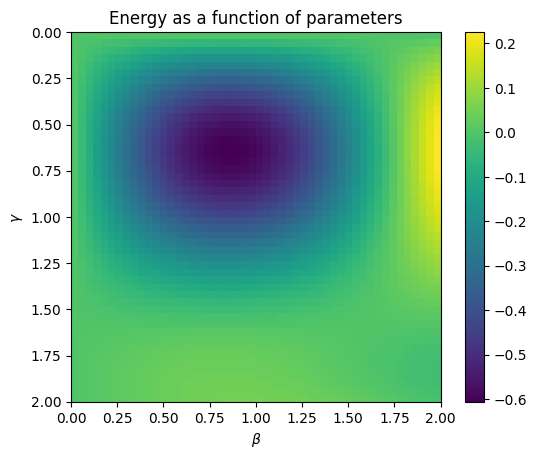

In [73]:
"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
import matplotlib.pyplot as plt

plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

In [74]:
gamma_value = gamma
beta_value = beta

bound_circuit = qc.assign_parameters({gamma_param: gamma, beta_param: beta})

# Submit to the Estimator
parameter_values = [[gamma_value, beta_value]]
job = estimator.run(bound_circuit)
print("Result:", result)

NameError: name 'estimator' is not defined